In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('train.csv')
print(df.shape, df.columns)
df.head()

(116058, 29) Index(['loan_id', 'source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13'],
      dtype='object')


,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,...,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,...,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,...,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,...,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,...,3,4,5,6,7,8,9,10,11,1


<h3> Exploratory Data Analysis

In [5]:
df.isnull().sum().sum()

0

In [6]:
numerical_features=df.select_dtypes(include=np.number)
categorical_features=df.select_dtypes(include=np.object)
print("numeric_features: ", numerical_features.shape, numerical_features.columns)
print("categorical_features: ", categorical_features.shape, categorical_features.columns)

numeric_features:  (116058, 24) Index(['loan_id', 'interest_rate', 'unpaid_principal_bal', 'loan_term',
       'loan_to_value', 'number_of_borrowers', 'debt_to_income_ratio',
       'borrower_credit_score', 'insurance_percent',
       'co-borrower_credit_score', 'insurance_type', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13'],
      dtype='object')
categorical_features:  (116058, 5) Index(['source', 'financial_institution', 'origination_date',
       'first_payment_date', 'loan_purpose'],
      dtype='object')


<h5> relationship with numeric variables

In [7]:
numerical_features.iloc[:,:11].describe()

,loan_id,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type
count,1.160580e+05,116058.000000,1.160580e+05,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000
mean,5.494155e+11,3.868961,2.082262e+05,292.280997,67.431939,1.593186,30.742293,769.926778,2.786288,459.611565,0.003257
std,2.597560e+11,0.461020,1.146851e+05,89.762415,17.291719,0.491242,9.730798,42.210706,8.096464,381.946926,0.056977
min,1.000009e+11,2.250000,1.100000e+04,60.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.244656e+11,3.500000,1.200000e+05,180.000000,57.000000,1.000000,23.000000,751.000000,0.000000,0.000000,0.000000
50%,5.486239e+11,3.875000,1.830000e+05,360.000000,72.000000,2.000000,31.000000,782.000000,0.000000,740.000000,0.000000
75%,7.743034e+11,4.125000,2.780000e+05,360.000000,80.000000,2.000000,39.000000,800.000000,0.000000,791.000000,0.000000
max,9.999971e+11,6.750000,1.200000e+06,360.000000,97.000000,2.000000,64.000000,840.000000,40.000000,836.000000,1.000000


In [9]:
#skewness & kurtosis
pd.DataFrame({"skewness":df.skew(),"kurtosis":df.kurt()})

,skewness,kurtosis
loan_id,0.004114,-1.197545
interest_rate,0.051326,0.169871
unpaid_principal_bal,0.897524,0.556988
loan_term,-0.692948,-1.293404
loan_to_value,-0.765251,0.078106
number_of_borrowers,-0.379397,-1.856090
debt_to_income_ratio,-0.194303,-0.825119
borrower_credit_score,-3.570945,48.502768
insurance_percent,2.743691,5.871008
co-borrower_credit_score,-0.362473,-1.849904


<ul><li>If skewness is less than −1 or greater than +1, the distribution is highly skewed. If skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed. If skewness is between −½ and +½, the distribution is approximately symmetric

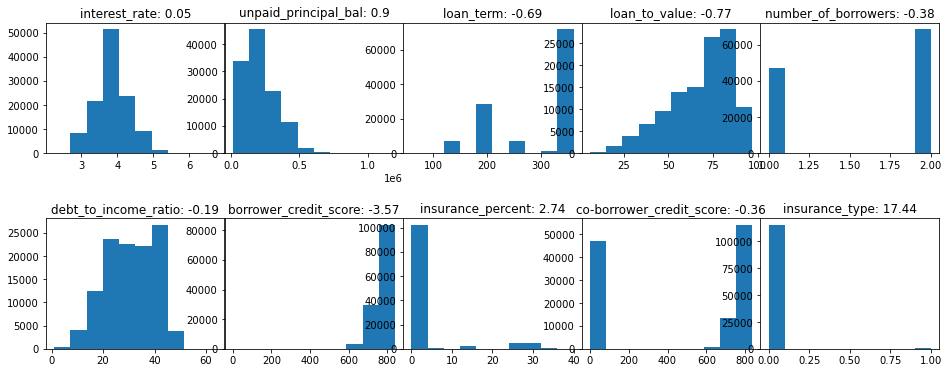

In [14]:
fig, axs = plt.subplots(2,5, figsize=(16, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i,j in zip([i for i in numerical_features.columns.to_list()[1:] if len(i) >3],range(10)):
    axs[j].hist(numerical_features[i])
    axs[j].set_title(i+': '+str(np.round(numerical_features[i].skew(),2)))

<ul><li>'interest_rate': normally distributed</li>
    <li>'unpaid_principal_bal': moderately right skewed</li>
        <li>'loan_term': moderately left skewed</li>
<li>'loan_to_value': moderately left skewed</li>
<li>'number_of_borrowers': symmetric (unique data point: 2)</li>
<li>'debt_to_income_ratio': normally distributed</li>
<li>'borrower_credit_score': left skewed (missing datapoints if 0?)</li>
<li>'insurance_percent': right skewed (mostly not insured)</li>
<li>'co-borrower_credit_score': left skewed (mostly not applicable, when # borrowers = 1)</li>
<li>'insurance_type': mostly 0 (Premium paid by borrower)</li>
<li>'m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13': Highly skewed (mostly zeros)</li>

In [18]:
numerical_features['m13'].value_counts()

0    115422
1       636
Name: m13, dtype: int64

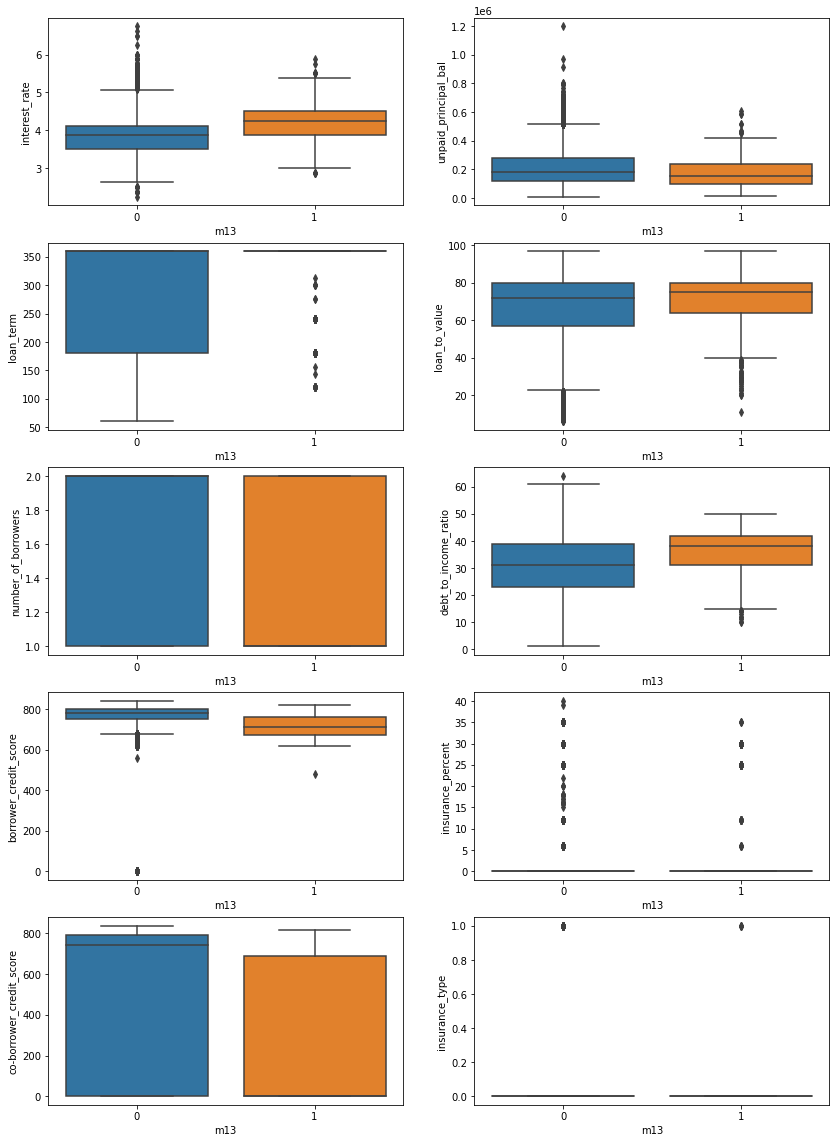

In [22]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9,ax10)) = plt.subplots(nrows=5, ncols=2, figsize=(14,20))
AX = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
for i,j in zip([i for i in numerical_features.columns.to_list()[1:] if len(i)>3],AX):
    sns.boxplot(x='m13',y=i,data=numerical_features,ax=j)

<ul><li>If 'borrower_credit_score is low, delinquency chances are high.</li>
<li>If 'debt_to_income_ratio' is high, delinquency chances are high.</li>
<li>If 'interest_rate' is high, delinquency chances are high.</li>
<li>Other variables are not showing any significant relationship with m13 delinquency</li>

In [23]:
cols = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']
for i in cols:
    print(pd.crosstab(numerical_features[i],numerical_features['m13']))

m13       0    1
m1              
0    115140  589
1       250   43
2        27    3
3         5    1
m13       0    1
m2              
0    115261  583
1       153   43
2         5    8
3         2    1
4         1    1
m13       0    1
m3              
0    115287  581
1       125   42
2         6    8
3         1    3
4         2    1
5         1    1
m13       0    1
m4              
0    115307  553
1       104   64
2         6   10
3         3    5
4         1    2
5         0    1
6         1    1
m13       0    1
m5              
0    115234  518
1       169   80
2        10   23
3         5    7
4         2    4
5         1    2
6         0    1
7         1    1
m13       0    1
m6              
0    115265  520
1       145   69
2         5   21
3         4   12
4         3    6
5         0    4
6         0    2
7         0    1
8         0    1
m13       0    1
m7              
0    115236  492
1       170   96
2        11   17
3         1   12
4         2    6
5         2   

In [24]:
df[cols].max(axis=0)

m1      3
m2      4
m3      5
m4      6
m5      7
m6      8
m7      9
m8     10
m9     11
m10    12
m11    13
m12    14
dtype: int64

<ul><li>m1 to m12: if delinquency is present only in later half of year, then chances of delinquency in m13 would be high</li>
<li>m1: Few values are 3, means first payment done after 3 months of 'origination_date'</li>

In [25]:
df['max_deliq']=df[cols].max(axis=1)

           max_deliq
count  116058.000000
mean        0.023325
std         0.235048
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        14.000000
m13             0    1
max_deliq             
0          113814  233
1            1497  229
2              78   66
3              18   39
4               8   18
5               2   10
6               1   13
7               2   10
8               2    5
9               0    4
10              0    4
11              0    4
14              0    1


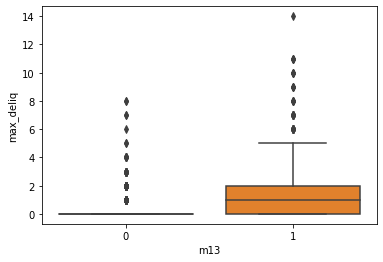

<AxesSubplot:xlabel='max_deliq', ylabel='m13'>

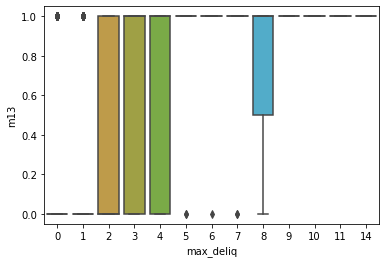

In [26]:
print(df[['max_deliq']].describe())
print(pd.crosstab(df['max_deliq'],df['m13']))
sns.boxplot('m13','max_deliq',data=df)
plt.show()
sns.boxplot('max_deliq','m13',data=df)

<AxesSubplot:>

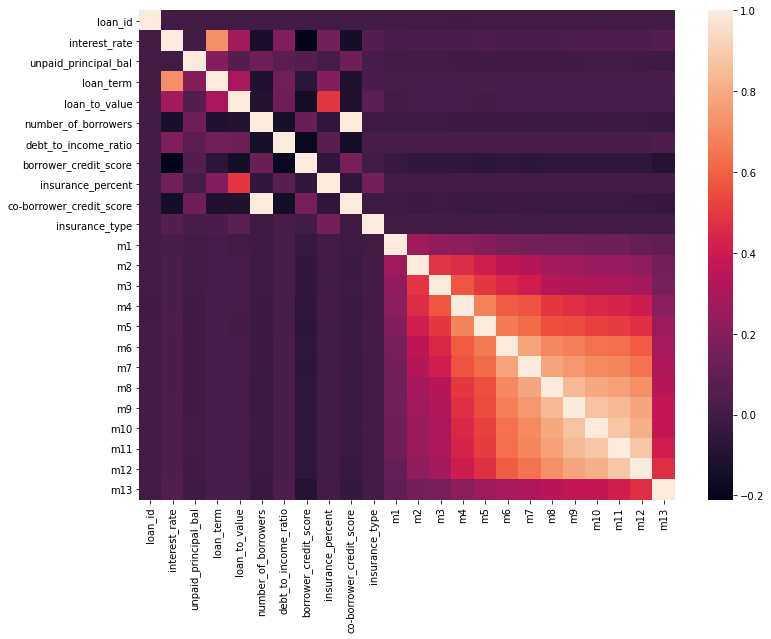

In [27]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(numerical_features.corr())

In [28]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(numerical_features.values, i) for i in range(numerical_features.shape[1])]
vif["features"] = numerical_features.columns
vif

,VIF Factor,features
0,5.460580,loan_id
1,2.166196,interest_rate
2,1.119231,unpaid_principal_bal
3,2.309670,loan_term
4,1.423870,loan_to_value
5,58.742619,number_of_borrowers
6,1.084515,debt_to_income_ratio
7,0.493528,borrower_credit_score
8,1.344911,insurance_percent
9,60.138336,co-borrower_credit_score


<ul><li>Multi-collinearity between m1 to m12 variables (mostly 2nd half of year)</li>
<li>'number_of_borrowers' & 'co-borrower_credit_score' are correlated to each other (will drop 'co-borrower_credit_score')</li>

<h4>categorical variables

In [30]:
categorical_features.shape, categorical_features.columns

((116058, 5),
 Index(['source', 'financial_institution', 'origination_date',
        'first_payment_date', 'loan_purpose'],
       dtype='object'))

In [31]:
for i in categorical_features.columns.to_list():
    print("Total unique values for",i,len(categorical_features[i].unique()))
    print("Value Counts for",i,'\n',categorical_features[i].value_counts(),'\n')

Total unique values for source 3
Value Counts for source 
 X    63858
Y    37554
Z    14646
Name: source, dtype: int64 

Total unique values for financial_institution 19
Value Counts for financial_institution 
 OTHER                          49699
Browning-Hart                  31852
Swanson, Newton and Miller      6874
Edwards-Hoffman                 4857
Martinez, Duffy and Bird        4715
Miller, Mcclure and Allen       3158
Nicholson Group                 2116
Turner, Baldwin and Rhodes      1846
Suarez Inc                      1790
Cole, Brooks and Vincent        1642
Richards-Walters                1459
Taylor, Hunt and Rodriguez      1259
Sanchez-Robinson                1193
Sanchez, Hays and Wilkerson      853
Romero, Woods and Johnson        750
Thornton-Davis                   651
Anderson-Taylor                  483
Richardson Ltd                   473
Chapman-Mcmahon                  388
Name: financial_institution, dtype: int64 

Total unique values for origination_date 3

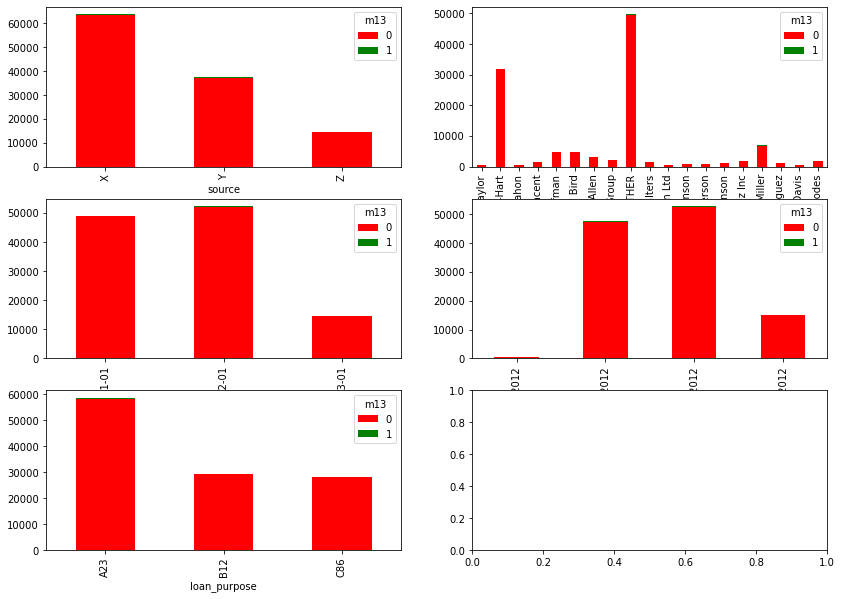

In [32]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(14,10))
AX = [ax1, ax2, ax3, ax4, ax5]

for i,j in zip(categorical_features.columns.to_list(),AX):
    temp = pd.crosstab(df[i],df['m13'])
    temp.plot(kind='bar',stacked=True,color=['red','green'],grid=False,ax=j)

In [33]:
for i in categorical_features.columns.to_list():
    print(pd.crosstab(df[i],df['m13']))

m13         0    1
source            
X       63553  305
Y       37307  247
Z       14562   84
m13                              0    1
financial_institution                  
Anderson-Taylor                480    3
Browning-Hart                31677  175
Chapman-Mcmahon                388    0
Cole, Brooks and Vincent      1630   12
Edwards-Hoffman               4816   41
Martinez, Duffy and Bird      4692   23
Miller, Mcclure and Allen     3139   19
Nicholson Group               2105   11
OTHER                        49430  269
Richards-Walters              1454    5
Richardson Ltd                 472    1
Romero, Woods and Johnson      748    2
Sanchez, Hays and Wilkerson    851    2
Sanchez-Robinson              1192    1
Suarez Inc                    1785    5
Swanson, Newton and Miller    6828   46
Taylor, Hunt and Rodriguez    1255    4
Thornton-Davis                 648    3
Turner, Baldwin and Rhodes    1832   14
m13                   0    1
origination_date            
2012-01

<ul><li>Deliquency in m13 is there when;</li>
<li>'        source' is either X or Y</li>
<li>'         financial_institution' is either 'Browning-Hart' or 'Other'</li>
<li>'         origination_date' is either Jan-12 or Feb-12</li>
<li>'         first_payment_date' is either Mar-12 or Apr-12</li>
<li>'         loan_purpose': either 'B12' or 'C86' (relatively)</li>
<li>           Above interpretation may not be true because mostly data also lies in these categories, so as deliquency</li>

<h3>feature engineering

In [36]:
# Loading raw_data again

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
#df_sample_submission = pd.read_csv('sample_submission.csv')

df_train.shape, df_test.shape

((116058, 29), (35866, 28))

In [37]:
df_train['origination_date'].unique(), df_train['first_payment_date'].unique()

(array(['2012-03-01', '2012-01-01', '2012-02-01'], dtype=object),
 array(['05/2012', '03/2012', '04/2012', '02/2012'], dtype=object))

In [38]:

df_test['origination_date'].unique(), df_test['first_payment_date'].unique()

(array(['01/02/12', '01/01/12', '01/03/12'], dtype=object),
 array(['Apr-12', 'Mar-12', 'May-12', 'Feb-12'], dtype=object))

In [39]:
df_test['m13'] = 'NA'
df = df_train.append(df_test, ignore_index=True)
print(df.shape)

(151924, 29)


In [40]:
df['origination_date'] = df['origination_date'].map({"2012-01-01": 1, "2012-02-01": 2, "2012-03-01": 3,
                                                     "01/01/12": 1, "01/02/12": 2, "01/03/12": 3})
df['first_payment_date'] = df['first_payment_date'].map({"02/2012":2, "03/2012":3, "04/2012":4, "05/2012":5,
                                                         "Feb-12":2, "Mar-12":3, "Apr-12":4, "May-12":5})

In [41]:
df['first_payment_delay'] = df['first_payment_date'] - df['origination_date']
pd.crosstab(df['first_payment_delay'], df['m13'])

m13,0,1,NA
first_payment_delay,,,
1,2976,17,884
2,108719,605,33878
3,3727,14,1104


In [42]:
df.isnull().sum().sum()

0

In [44]:
df['financial_institution_new'] = df['financial_institution'].apply(lambda x:1if (x=='Browning-Hart') or (x=='OTHER') else 0)
df['source_new'] = df['source'].apply(lambda x: 1 if (x == 'X') or (x == 'Y') else 0)
print(df['financial_institution_new'].value_counts())
print(df['source_new'].value_counts())

1    106791
0     45133
Name: financial_institution_new, dtype: int64
1    132779
0     19145
Name: source_new, dtype: int64


In [46]:
temp = pd.get_dummies(df['financial_institution'])
df = df.join(temp)
print(df.shape)

(151924, 51)


In [47]:
temp = pd.get_dummies(df['source'])
df = df.join(temp)
print(df.shape)

temp = pd.get_dummies(df['loan_purpose'])
df = df.join(temp)
print(df.shape)

(151924, 54)
(151924, 57)


In [48]:
cols = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']

# creating new column: maximum deliquency time month
df['max_deliq'] = df[cols].max(axis=1)

In [50]:
df['m12_new'] = df['m12'].apply(lambda x: 1 if x > 0 else 0)
print(df['m12_new'].value_counts())
print(pd.crosstab(df['m12_new'],df['m13']))

0    151281
1       643
Name: m12_new, dtype: int64
m13           0    1     NA
m12_new                    
0        115221  336  35724
1           201  300    142


In [51]:
df['last3_months'] = 0
df.loc[(df['m10'] > 0) | (df['m11'] > 0) | (df['m12'] > 0),'last3_months'] = 1

print(df['last3_months'].value_counts())
pd.crosstab(df['last3_months'],df['m13'])

0    150753
1      1171
Name: last3_months, dtype: int64


m13,0,1,NA
last3_months,,,
0,114864,279,35610
1,558,357,256


In [52]:
df1 = df.drop(['loan_id','source','financial_institution','origination_date','first_payment_date','loan_purpose'],axis=1)

<h3>recursive feature engineering(dimenstinality reduction)

In [53]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier

In [54]:
train = df1.iloc[:116058,:]
xtrain, xtest, ytrain, ytest = train_test_split(train, df_train['m13'].values.ravel(), random_state=42, test_size=0.1)
X = xtrain
y = ytrain

<h4>Logistic Regression

In [58]:
n_feat = [8,10,12,15,20]
for n in n_feat:
    model = LogisticRegression()
    rfe = RFE(model, n_features_to_select = n)
    rfe = rfe.fit(X, y)
    cols = X.columns.tolist()
    sel_feat = pd.DataFrame({"cols": cols, "support": rfe.support_, "rank": rfe.ranking_})
    print("Top features: ", n)
    print(rfe.score(X, y))
    print(f1_score(ytest, rfe.predict(xtest)))
    print(sel_feat[sel_feat['rank'] == 1]['cols'].unique(), '\n')

Top features:  8
1.0
1.0
['interest_rate' 'number_of_borrowers' 'm10' 'm13' 'Edwards-Hoffman'
 'max_deliq' 'm12_new' 'last3_months'] 

Top features:  10
1.0
1.0
['interest_rate' 'number_of_borrowers' 'm10' 'm12' 'm13' 'Edwards-Hoffman'
 'B12' 'max_deliq' 'm12_new' 'last3_months'] 

Top features:  12
1.0
1.0
['interest_rate' 'number_of_borrowers' 'm10' 'm12' 'm13' 'Edwards-Hoffman'
 'X' 'A23' 'B12' 'max_deliq' 'm12_new' 'last3_months'] 

Top features:  15
1.0
1.0
['interest_rate' 'number_of_borrowers' 'm3' 'm10' 'm11' 'm12' 'm13'
 'first_payment_delay' 'Edwards-Hoffman' 'X' 'A23' 'B12' 'max_deliq'
 'm12_new' 'last3_months'] 

Top features:  20
1.0
1.0
['interest_rate' 'number_of_borrowers' 'm3' 'm6' 'm9' 'm10' 'm11' 'm12'
 'm13' 'first_payment_delay' 'source_new' 'Edwards-Hoffman' 'X' 'Y' 'Z'
 'A23' 'B12' 'max_deliq' 'm12_new' 'last3_months'] 

